In [2]:
# preparing data
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import torch
import math
import os
from os import path
import torch.nn as nn

NETWORK_DATA = True

"""___________________Hyper Parameters________________________"""
CROSS_VALIDATION_SHUFFLE = True
TRIM_DATA = True
FILTER_CORRCOEF = True
DENOISE = False
NORMALIZE_DATA = False
LATENT_DIM = 16
HIDDEN_DIM = 4
WEIGHT_DECAY = 0
LEARNING_RATE = 1e-5
ACTIVATION = 'leaky_relu'
OUTPUT_DIM = 1
PREDICTING_INDEX = 0
"""___________________________________________________________"""
# collapse
if NETWORK_DATA:
    raw_data = np.loadtxt('../data/network_flow_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_data = np.loadtxt('../data/network_flow_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
else:
    raw_data = np.loadtxt('../data/medical_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_data = np.loadtxt('../data/medical_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
# collapse here

if True:
    len_raw_data = len(raw_data)
    PROPORTION_TRAIN = 0.6
    PROPORTION_VALIDATION = 0.2
    PROPORTION_TEST = 0.2
    if CROSS_VALIDATION_SHUFFLE:
        random_idc = np.random.choice(len_raw_data, len_raw_data, replace=False)
        raw_data = raw_data[random_idc,:]
    train_data = torch.tensor(raw_data[0:math.floor(len_raw_data * PROPORTION_TRAIN)])
    validation_data = torch.tensor(raw_data[math.floor(len_raw_data * PROPORTION_TRAIN):math.floor(len_raw_data * (PROPORTION_TRAIN + PROPORTION_VALIDATION))])
    test_data = torch.tensor(raw_data[math.floor(len_raw_data * (PROPORTION_TRAIN + PROPORTION_VALIDATION)):])

    train_data = train_data.to(torch.float32)
    validation_data = validation_data.to(torch.float32)
    test_data = test_data.to(torch.float32)
    anomalous_data = torch.tensor(anomalous_data).to(torch.float32)

    if TRIM_DATA:
        train_data = torch.cat((train_data[::, 2:-5], train_data[::, -3:]), 1)
        validation_data = torch.cat((validation_data[::, 2:-5], validation_data[::, -3:]), 1)
        test_data = torch.cat((test_data[::, 2:-5], test_data[::, -3:]), 1)
        anomalous_data = torch.cat((anomalous_data[::, 2:-5], anomalous_data[::, -3:]), 1)
    #print(torch.corrcoef(torch.t(train_data)).numpy())

    # this ensures that the current MacOS version is at least 12.3+
    print(torch.backends.mps.is_available())
    # this ensures that the current current PyTorch installation was built with MPS activated.
    print(torch.backends.mps.is_built())
    import platform
    print(platform.platform())
    if FILTER_CORRCOEF:
        train_data = torch.cat((train_data[::, 0:1], train_data[::, 2:-2]), 1)
        validation_data = torch.cat((validation_data[::, 0:1], validation_data[::, 2:-2]), 1)
        test_data = torch.cat((test_data[::, 0:1], test_data[::, 2:-2]), 1)
        anomalous_data = torch.cat((anomalous_data[::, 0:1], anomalous_data[::, 2:-2]), 1)
    if NORMALIZE_DATA:
        eps = 1e-5
        train_mu = torch.mean(train_data, 0, True)
        train_std = torch.std(train_data, dim=0, unbiased=True, keepdim=True)
        print("Train data std: ", train_std)
        train_data = (train_data - train_mu) / (train_std + eps)
        validation_data = (validation_data - torch.mean(validation_data, 0, True)) / (train_std + eps)
        test_data = (test_data - train_mu) / (train_std + eps)
        anomalous_data = (anomalous_data - train_mu) / (train_std + eps)

# use gpu if available
#device = torch.device("mps")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_data = train_data.to(device)
validation_data = validation_data.to(device)
test_data = test_data.to(device)
anomalous_data = anomalous_data.to(device)
train_y, validation_y, test_y, anomalous_y = train_data[:,PREDICTING_INDEX], validation_data[:,PREDICTING_INDEX], test_data[:,PREDICTING_INDEX], anomalous_data[:,PREDICTING_INDEX]
train_X, validation_X, test_X, anomalous_X = np.delete(train_data, PREDICTING_INDEX, axis=1), np.delete(validation_data, PREDICTING_INDEX, axis=1), np.delete(test_data, PREDICTING_INDEX, axis=1), np.delete(anomalous_data, PREDICTING_INDEX, axis=1)

NUM_FEATURE = len(train_data[0]) - OUTPUT_DIM


True
True
macOS-13.0-arm64-arm-64bit


In [44]:
# AE class
class AutoEncoder(nn.Module):
    def _init_weights(self, module):
        #torch.nn.init.kaiming_normal_(module.weight.data, a=0, mode='fan_in', nonlinearity='leaky_relu')
        torch.nn.init.xavier_normal_(module.weight, gain=torch.nn.init.calculate_gain(nonlinearity='linear'))
        if module.bias is not None:
            module.bias.data.zero_()

    def __init__(self, num_feature=16, latend_dim=4, hidden_dim=8, activation='leaky_relu', **kwargs) -> None:
        super().__init__()
        self.num_feature = num_feature
        self.latent_dim = latend_dim
        hd = hidden_dim
        self.KLD = 0
        self.output_dim = OUTPUT_DIM
        self.l1 = nn.Linear(num_feature, hd)
        self.l2 = nn.Linear(hd, hd)
        self.l3 = nn.Linear(hd, hd)
        self.generate_mean = nn.Linear(hd, latend_dim)
        self.generate_var = nn.Linear(hd, latend_dim)
        self.l5 = nn.Linear(latend_dim, hd)
        self.l6 = nn.Linear(hd, hd)
        self.l7 = nn.Linear(hd, hd)
        self.l8 = nn.Linear(hd, self.output_dim)

        if activation == 'leaky_relu':
            self.encoding_layer = nn.Sequential(
                self.l1,
                nn.LeakyReLU(0.1),
                #nn.BatchNorm1d(hd),
                self.l2,
                nn.LeakyReLU(0.1),
                #nn.BatchNorm1d(hd),
                self.l3,
                nn.LeakyReLU(0.1),
                #nn.BatchNorm1d(hd),
            )  
            self.decoding_layer = nn.Sequential(
                self.l5,
                nn.LeakyReLU(0.1),
                #nn.BatchNorm1d(hd),
                self.l6,
                nn.LeakyReLU(0.1),
                #nn.BatchNorm1d(hd),
                self.l7,
                nn.LeakyReLU(0.1),
                #nn.BatchNorm1d(hd),
                self.l8,
            )
        elif activation == 'tanh':
            self.encoding_layer = nn.Sequential(
                self.l1,
                nn.Tanh(),
                #nn.BatchNorm1d(hd),
                self.l2,
                nn.Tanh(),
                #nn.BatchNorm1d(hd),
                self.l3,
                nn.Tanh(),
                #nn.BatchNorm1d(hd),
            )  
            self.decoding_layer = nn.Sequential(
                self.l5,
                nn.Tanh(),
                #nn.BatchNorm1d(hd),
                self.l6,
                nn.Tanh(),
                #nn.BatchNorm1d(hd),
                self.l7,
                nn.Tanh(),
                #nn.BatchNorm1d(hd),
                self.l8
            )
        elif activation == 'sigmoid':
            self.encoding_layer = nn.Sequential(
                self.l1,
                nn.Sigmoid(),
                #nn.BatchNorm1d(hd),
                self.l2,
                nn.Sigmoid(),
                #nn.BatchNorm1d(hd),
                self.l3,
                nn.Sigmoid(),
                #nn.BatchNorm1d(hd),
            )  
            self.decoding_layer = nn.Sequential(
                self.l5,
                nn.Sigmoid(),
                #nn.BatchNorm1d(hd),
                self.l6,
                nn.Sigmoid(),
                #nn.BatchNorm1d(hd),
                self.l7,
                nn.Sigmoid(),
                #nn.BatchNorm1d(hd),
                self.l8,
            )

        self._init_weights(self.l1)
        self._init_weights(self.l2)
        self._init_weights(self.l3)
        self._init_weights(self.generate_mean)
        self._init_weights(self.generate_var)
        self._init_weights(self.l5)
        self._init_weights(self.l6)
        self._init_weights(self.l7)
        self._init_weights(self.l8)
    
    def reparameterize(self, mu, var):
        std = torch.sqrt(var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        self.KLD = -0.5 * torch.sum(1 + torch.log(var) - mu**2 - var) / self.latent_dim
        #print("eps = {}, var = {}, std = {}, KLD = {}".format(eps, var, std, self.KLD))
        #torch.ones(mu.size())
        #self.KLD = 0.5 * (torch.exp(var) + mu**2 - var - 1)
        return sample
        
    def encode(self, x):
        x = self.encoding_layer(x)
        mu, var = self.generate_mean(x), self.generate_var(x)**2
        return self.reparameterize(mu, var)
    def decode(self, x):
        return self.decoding_layer(x)

    def forward(self, x):
        return self.l8(self.l2(self.l1(x)))
        return self.decode(self.encode(x))


In [45]:
# initialize model
BATCH_SIZE = 128
# collapse
if True:
    model = AutoEncoder(num_feature=NUM_FEATURE, latend_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM, activation=ACTIVATION).to(device)

    # mean-squared error loss
    criterion = nn.MSELoss(reduction='sum')
    

In [46]:
# train
epochs = 2000
sigma = 1
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
loss_array = []
#model.load_state_dict(torch.load('../model/param_AE'))
model.train()
l = len(train_data)
for epoch in range(epochs):
    loss = 0
    kl = 0
    permutation = np.random.permutation(l)
    for i in range(0, l, BATCH_SIZE):
        batch_idc = permutation[i:i+BATCH_SIZE]
        batch = train_X[batch_idc,]
        batch_y = train_y[batch_idc,]
        optimizer.zero_grad()
        # compute reconstructions
        outputs = model(batch)
        #print(outputs.shape, batch_y.shape)
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_y.view(len(outputs), 1)) 
        #+ sigma * model.KLD
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
        #kl += model.KLD
        
        train_loss /= len(batch)
        # compute accumulated gradients
        train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1e1)
        
        # perform parameter update based on current gradients
        optimizer.step()
    
    # compute the epoch training loss
    loss /= l
    kl /= l
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}, KLD = {}".format(epoch + 1, epochs, loss, kl))
    loss_array.append(loss)

torch.save(model.state_dict(), '../model/param_AE')

epoch : 1/2000, loss = 54555951458.082695, KLD = 0.0
epoch : 2/2000, loss = 54551110979.765648, KLD = 0.0
epoch : 3/2000, loss = 54546279114.049721, KLD = 0.0
epoch : 4/2000, loss = 54541436572.638100, KLD = 0.0
epoch : 5/2000, loss = 54536600220.510178, KLD = 0.0
epoch : 6/2000, loss = 54531773234.176643, KLD = 0.0
epoch : 7/2000, loss = 54526931576.948410, KLD = 0.0
epoch : 8/2000, loss = 54522111631.334419, KLD = 0.0
epoch : 9/2000, loss = 54517271414.997627, KLD = 0.0
epoch : 10/2000, loss = 54512445280.099937, KLD = 0.0
epoch : 11/2000, loss = 54507617016.612617, KLD = 0.0
epoch : 12/2000, loss = 54502774868.171394, KLD = 0.0
epoch : 13/2000, loss = 54497937042.404495, KLD = 0.0
epoch : 14/2000, loss = 54493094009.779884, KLD = 0.0
epoch : 15/2000, loss = 54488260670.424988, KLD = 0.0
epoch : 16/2000, loss = 54483413216.883446, KLD = 0.0
epoch : 17/2000, loss = 54478579681.043350, KLD = 0.0
epoch : 18/2000, loss = 54473738580.523170, KLD = 0.0
epoch : 19/2000, loss = 54468887459.2

KeyboardInterrupt: 

In [ ]:
# evaluation
#model.load_state_dict(torch.load('../model/param_AE'))
model.eval()
validation_batch_size = 1
permutation = np.random.permutation(len(validation_data))
for i in range(0, len(validation_data), validation_batch_size):
    batch_idc = permutation[i:i+validation_batch_size]
    batch = validation_X[batch_idc,]
    batch_y = validation_y[batch_idc,]
    loss = 0
    # compute reconstructions
    outputs = model(batch)

    print(f"input:{batch[0].data}\noutput:{outputs[0].data}")
    
    # compute the epoch validation loss
    loss = criterion(outputs, batch_y.view(len(outputs), 1)).item()
    loss /= len(batch)
    #i_loss = torch.sum(torch.square(batch[0]-outputs[0]))
    print(f"Batch Average Reconstruciton Loss:{loss}")

input:tensor([  3.9290,   2.4395,   2.9182,   2.3965, 682.0000])
output:tensor([223321.8125])
Batch Average Reconstruciton Loss:850316544.0
input:tensor([  6.7113,   4.7900,   4.7676,   4.7230, 682.0000])
output:tensor([223189.1250])
Batch Average Reconstruciton Loss:5682012672.0
input:tensor([  3.5383,   1.8735,   2.8511,   1.8065, 682.0000])
output:tensor([223347.5156])
Batch Average Reconstruciton Loss:3250195456.0
input:tensor([  4.2147,   2.8240,   3.0349,   2.8060, 682.0000])
output:tensor([223303.1875])
Batch Average Reconstruciton Loss:145583824.0
input:tensor([  5.2080,   2.7665,   4.1484,   2.7325, 682.0000])
output:tensor([223283.1406])
Batch Average Reconstruciton Loss:1076308480.0
input:tensor([  3.8130,   2.4060,   2.8079,   2.3470, 682.0000])
output:tensor([223325.8281])
Batch Average Reconstruciton Loss:1356977280.0
input:tensor([  4.0013,   2.4005,   3.0274,   2.3255, 682.0000])
output:tensor([223322.0781])
Batch Average Reconstruciton Loss:604910208.0
input:tensor([  

In [ ]:
# test
#model.load_state_dict(torch.load('../model/param_AE'))
model.eval()
model_name = "VAE"

# Collapse
if True:
    loss_test = []
    lcs_array = torch.tensor([[0 for _ in range(NUM_FEATURE)]])

    y_scores = []
    y_scores_lcs = []
    kl_div_test = []
    y_ground_truth = []
    # Define KL Loss
    kl_loss = nn.KLDivLoss(reduction="batchmean", log_target=False)
    l = len(test_data)
    permutation = np.random.permutation(l)
    for i in range(0, l, 1):
        batch_idc = permutation[i:i+1]
        batch = test_X[batch_idc,]
        batch_y = test_y[batch_idc,]
        loss = 0
        
        # compute reconstructions
        outputs = model(batch)

        #print(f"input:{batch[0].data}\noutput:{outputs[0].data}")
        
        # compute the epoch test loss
        loss = criterion(outputs, batch_y).item()
        # append loss and class label
        y_scores.append(loss)
        y_ground_truth.append(0)
        #i_loss = torch.sum(torch.square(batch[0]-outputs[0]))
        loss_test.append(loss)
        #print(f"Reconstruciton Loss:{loss}")
    #________________________________________________________________________#

    # anomaly detection test
    loss_attack =[]
    l = len(anomalous_data)
    permutation = np.random.permutation(l)
    for i in range(0, l, 1):
        batch_idc = permutation[i:i+1]
        batch = anomalous_X[batch_idc,]
        batch_y = anomalous_y[batch_idc,]
        loss = 0
        # compute reconstructions
        outputs = model(batch)
        # compute the epoch test loss
        loss = criterion(outputs, batch_y).item()
        # append loss and class label
        y_scores.append(loss)
        y_ground_truth.append(1)
        loss_attack.append(loss)
        #print(f"Reconstruciton Loss:{loss}")



/Users/xxd/Documents/Course/MIE696/mie696/.venv/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


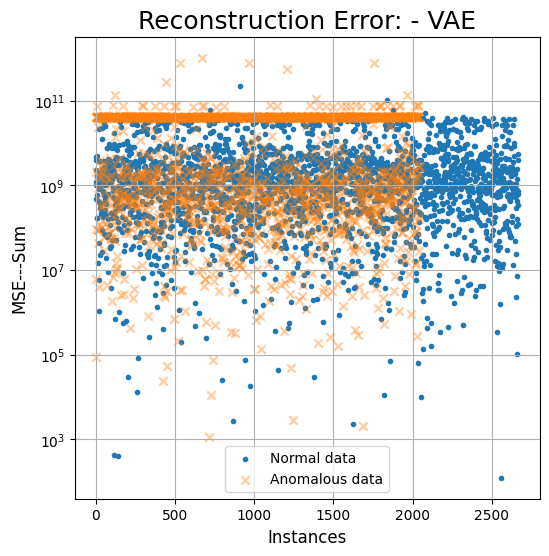

In [ ]:
import matplotlib.pyplot as plt
if True:
    fig = plt.figure(figsize = (6,6))

    ax = fig.add_subplot(1,1,1)

    ax.set_xlabel('Instances', fontsize = 12)
    ax.set_ylabel('MSE---Sum', fontsize = 12)
    ax.set_yscale('log')
    #ax.set_ylim(1e2, 1e9)
    ax.set_title('Reconstruction Error: - ' + model_name, fontsize = 18)
    ax.grid()
    a = ax.scatter(np.arange(len(loss_test)), loss_test, marker=".")
    b = ax.scatter(np.arange(len(loss_attack)), loss_attack, marker="x", alpha=0.4)
    a.set_label('Normal data')
    b.set_label('Anomalous data')
    ax.legend()


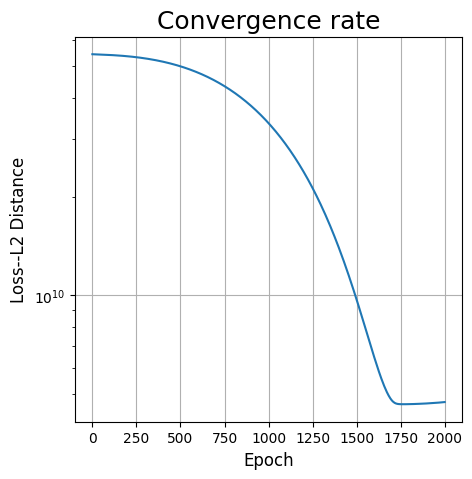

In [ ]:
# Convergence Rate
if True:
    fig = plt.figure(figsize = (5, 5))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Epoch', fontsize = 12)
    ax.set_ylabel('Loss--L2 Distance', fontsize = 12)
    ax.set_yscale('log')
    #ax.set_ylim(1e5, 1e9)
    ax.set_title('Convergence rate', fontsize = 18)
    ax.grid()
    a = ax.plot(loss_array)

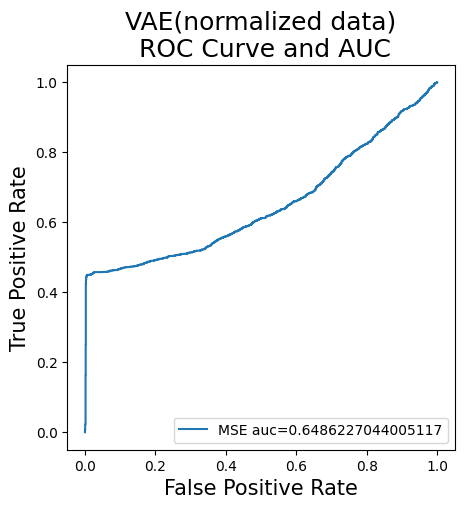

In [ ]:
# ROC & AUC
from sklearn import metrics
if True:
    fig = plt.figure(figsize = (5,5))
    ax = fig.add_subplot(1,1,1) 

    fpr_MSE, tpr_MSE, _ = metrics.roc_curve(y_ground_truth,  y_scores)
    auc_MSE = metrics.roc_auc_score(y_ground_truth,  y_scores)

    ax.set_title(model_name+'(normalized data)\n ROC Curve and AUC', fontsize = 18)
    ax.plot(fpr_MSE,tpr_MSE, label="MSE auc="+str(auc_MSE))
    ax.set_xlabel("False Positive Rate", fontsize=15)
    ax.set_ylabel("True Positive Rate", fontsize=15)
    ax.legend(loc=4)

In [7]:
# test block
import itertools
mu, std = torch.rand(4, 16), torch.exp(torch.rand(4, 16))**0.5
KLD = torch.distributions.kl.kl_divergence(torch.distributions.normal.Normal(mu, std), torch.distributions.normal.Normal(torch.zeros_like(mu), torch.ones_like(std)))
KLD1 = -0.5 * (1 + torch.log(std**2) - mu**2 - std**2) # KL divergence with N(0, 1)
print(np.unique(np.array([[1,1], [2,1],[1,1]])[:,1], return_counts=True)[1])
for item in locals().items():
    print(item)
print("CE", nn.BCELoss(reduction='none')(torch.tensor([.2,.5,.9,.1]), torch.tensor([1.0,1.0,1.0,1.0])))
a = np.random.rand(10, 2)
print(np.concatenate((a, a, np.ones((10, 1))), axis=1))

sd = torch.randint(0, 5, (3, 2, 1))
print(sd)
sigma = sd * sd.view(3, 1, 2)
print(sigma)
print(sigma.shape)
print(torch.eye(3).expand(4, 3, 3))

Sigma = torch.rand(2, 2) + torch.eye(2) * 1e-6
Sigma = Sigma.T * Sigma
print(Sigma.shape)
Sigma2 = Sigma.expand(4, 2, 2)
torch.mul(torch.rand(4, 2, 2), torch.rand(4, 2, 1)).shape

p = torch.distributions.normal.Normal(torch.rand(16, 4), torch.randint(1, 3, (16, 4)))
q = torch.distributions.normal.Normal(torch.rand(16, 4), torch.randint(1, 3, (16, 4)))

torch.distributions.kl.kl_divergence(p, q)

[3]
('__name__', '__main__')


RuntimeError: dictionary changed size during iteration